<a href="https://colab.research.google.com/github/YulieRu/NN_msu/blob/master/3_pinn_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 11.4 MB/s eta 0:00:00


In [ ]:
import deepxde as dde

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
import numpy as np

In [ ]:
# computational domain

geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [ ]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)

    return (dy_t - dy_xx*0.3)

In [ ]:
# condition equations

def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

bc = dde.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial)


In [ ]:
# Training data

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=4000,
    num_boundary=2000,
    num_initial=1000,
    solution=func,
    num_test=1000,
)

In [ ]:
layer_size = [2] + [32]*3 + [1]
activation = 'tanh'

initializer = 'Glorot uniform'
optimizer = 'adam'

net = dde.maps.FNN(layer_size, activation, initializer)

In [ ]:
#compile the model
model = dde.Model(data, net)
model.compile('adam', lr=0.001, metrics=['l2 relative error'])

Compiling model...
Building feed-forward neural network...
'build' took 0.184774 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.777133 s



In [ ]:
#train the model
losshistory, train_state = model.train(epochs=10000)

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [5.02e-02, 4.70e-02, 3.85e-01]    [5.03e-02, 4.70e-02, 3.85e-01]    [9.51e-01]    
1000      [7.11e-04, 3.53e-04, 2.24e-04]    [7.77e-04, 3.53e-04, 2.24e-04]    [2.82e-01]    
2000      [1.85e-04, 7.79e-05, 5.98e-05]    [2.18e-04, 7.79e-05, 5.98e-05]    [2.79e-01]    
3000      [9.80e-05, 8.31e-05, 6.11e-05]    [1.20e-04, 8.31e-05, 6.11e-05]    [2.78e-01]    
4000      [5.15e-05, 9.90e-06, 1.30e-05]    [7.01e-05, 9.90e-06, 1.30e-05]    [2.82e-01]    
5000      [3.36e-05, 4.45e-06, 7.28e-06]    [4.55e-05, 4.45e-06, 7.28e-06]    [2.82e-01]    
6000      [2.37e-05, 2.13e-06, 3.43e-06]    [3.26e-05, 2.13e-06, 3.43e-06]    [2.81e-01]    
7000      [1.90e-05, 1.63e-06, 2.17e-06]    [2.54e-05, 1.63e-06, 2.17e-06]    [2.82e-01]    
8000      [1.63e-05, 1.67e-06, 2.09e-06]    [2.06e-05, 1.67e-06, 2.09e-06]    [2.81e-01]    
9000      [2.04e-05, 5.35e-06, 2.81e-06]    [2.21e-

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


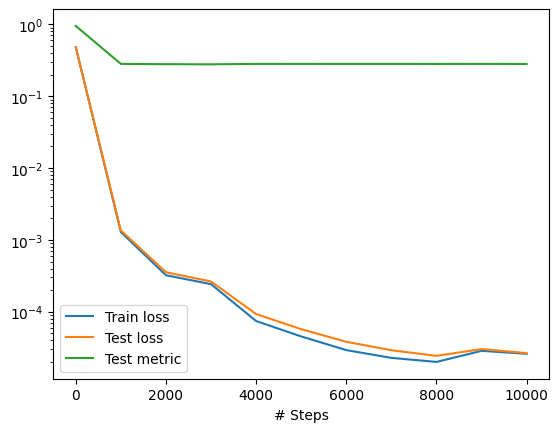

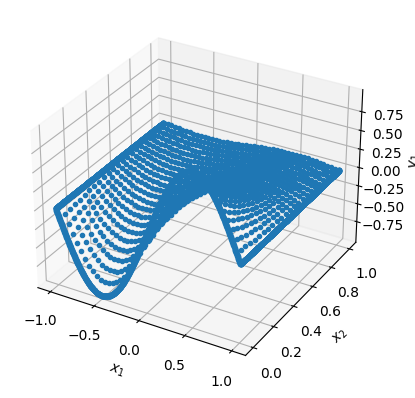

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [ ]:
x_data = np.linspace(-1, 1, num=100)
t_data = np.linspace(0, 1, num=100)
test_x, test_t = np.meshgrid(x_data, t_data)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_t))).T
predicted_solution = model.predict(test_domain)
residual = model.predict(test_domain, operator=pde)

In [ ]:
predicted_solution.shape

(10000, 1)

In [ ]:
predicted_solution_xt = predicted_solution.reshape((100, 100))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.pcolor(test_x, test_t, predicted_solution_xt, cmap='jet')
plt.show()

NameError: ignored